In [ ]:
# when using google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/MyDrive/Anmedsos 2022 Mid-Term Project Released Data/"
path = "/content/gdrive/MyDrive/TERM 8/ANAMEDSOS/TUGAS KELOMPOK/TK 1 - DEMOGRAPHICS PREDICTION/"

In [ ]:
!pip install nltk
!pip install plotly
!pip install gensim
!pip install tqdm
!pip install xgboost

import numpy as np
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import OrderedDict, Counter
from wordcloud import WordCloud
from tqdm import tqdm

from gensim import corpora, models, similarities
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Collection

In [ ]:
df_profile = pd.read_excel(dataset_path+"df_training_labeled_structured.xlsx")
df_profile

,created_at,description,followers_count,following_count,gender,listed_count,location,name,occupation,tweet_count,username,verified
0,2009-05-30,NaN,480.0,1018.0,wanita,5.0,NaN,Atika Mutiara,sosial kemasyarakatan,21752.0,_atikamutiara,0.0
1,2009-07-27,Fearfully and wonderfully made. A traveller bo...,49759.0,592.0,wanita,78.0,Inside your heaven,Lolita Agustine,sains dan teknologi,34002.0,lolitagustine,0.0
2,2009-04-18,Penulis FILOSOFI TERAS. Ketua Umum Partai Kead...,166639.0,932.0,pria,615.0,Jakarta,Henry Manampiring,hiburan,142258.0,newsplatter,1.0
3,2010-10-05,NaN,512976.0,1326.0,pria,368.0,NaN,Lukman H. Saifuddin,sosial kemasyarakatan,32942.0,lukmansaifuddin,1.0
4,2009-04-21,Founder of Drone Emprit and Media Kernels Indo...,115656.0,1589.0,pria,210.0,"Jakarta Selatan, DKI Jakarta",Ismail Fahmi,sains dan teknologi,42779.0,ismailfahmi,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10862,2012-02-28,Official Twitter account of Nelson Alom. Insta...,7035.0,48.0,pria,15.0,"Papua, Indonesia",Nelson Alom,olahraga,3257.0,nelsonalom90,0.0
10863,2011-06-07,My Wife Eva Triyana Tjan 💍,17529.0,401.0,pria,10.0,Jakarta,Abduh Lestaluhu,olahraga,1830.0,abduh03,0.0
10864,2011-01-31,NaN,471.0,68.0,pria,2.0,"Bekasi Barat, Indonesia",Arapenta LP,olahraga,929.0,arapenta_lp,0.0
10865,2010-04-20,Part time dreamer.,17104.0,344.0,pria,4.0,NaN,Lenzivio adixi,olahraga,34424.0,alenzivio,0.0


In [ ]:
print(df_profile.columns)

Index(['created_at', 'description', 'followers_count', 'following_count',
       'gender', 'listed_count', 'location', 'name', 'occupation',
       'tweet_count', 'username', 'verified'],
      dtype='object')


# Exploratory Data Analysis

## User Profile Data


In [ ]:
df_profile.sample(5)

,created_at,description,followers_count,following_count,gender,listed_count,location,name,occupation,tweet_count,username,verified
10852,2010-06-30,Reds Forever And Basketball,390.0,326.0,pria,2.0,NaN,hendra surya,olahraga,24665.0,khoe_hen,0.0
2257,2010-03-28,A Man with Simple Life | Members of ORX (Open ...,722.0,955.0,pria,5.0,Indonesia,ACHMAD YANI 🏅,-,13334.0,ay4ni,0.0
7844,2011-06-09,"Only God can judge me, the rest of others are ...",205.0,198.0,wanita,0.0,Indonesia,ナビら,sosial kemasyarakatan,2431.0,puntengozaimasu,0.0
6362,2010-06-20,"PRODUSEN baju anak homemade rumahan, termurah ...",152.0,239.0,wanita,2.0,JOGJAKARTA,Ndalem_mfa,-,7169.0,kenshinhermawan,0.0
5477,2017-07-31,NaN,141.0,389.0,wanita,0.0,Jakarta Capital Region,Angling Dharma,-,4099.0,iknowid,0.0


In [ ]:
df_profile.shape

(10867, 12)

In [ ]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   created_at       10867 non-null  datetime64[ns]
 1   description      8222 non-null   object        
 2   followers_count  10867 non-null  float64       
 3   following_count  10867 non-null  float64       
 4   gender           10867 non-null  object        
 5   listed_count     10867 non-null  float64       
 6   location         7097 non-null   object        
 7   name             10865 non-null  object        
 8   occupation       10867 non-null  object        
 9   tweet_count      10867 non-null  float64       
 10  username         10867 non-null  object        
 11  verified         10867 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 1018.9+ KB


In [ ]:
df_profile.isnull().sum()

created_at            0
description        2645
followers_count       0
following_count       0
gender                0
listed_count          0
location           3770
name                  2
occupation            0
tweet_count           0
username              0
verified              0
dtype: int64

In [ ]:
df_profile.describe()

,followers_count,following_count,listed_count,tweet_count,verified
count,1.086700e+04,10867.000000,1.086700e+04,1.086700e+04,10867.000000
mean,5.486852e+04,697.728444,3.895213e+02,1.346235e+04,0.023189
std,8.872406e+05,3957.892937,2.982718e+04,4.356179e+04,0.150512
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,5.700000e+01,99.000000,0.000000e+00,5.310000e+02,0.000000
50%,2.660000e+02,282.000000,0.000000e+00,3.584000e+03,0.000000
75%,1.038500e+03,648.000000,2.000000e+00,1.270950e+04,0.000000
max,7.936502e+07,301883.000000,3.095544e+06,2.566432e+06,1.000000


##Gender Ratio

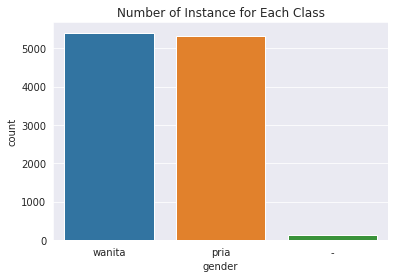

In [ ]:
sns.countplot(x='gender', data=df_profile)
plt.title('Number of Instance for Each Class')
plt.show()

# Data Preprocessing

## Data Selection


Memilih atribut yang akan diproses dan dipelajari oleh model.

In [ ]:
df_res_profile = df_profile[['name', 'username', 'description', 'gender']]

In [ ]:
num_cols = df_profile.select_dtypes(include=np.number).columns.tolist()
num_df = df_profile[num_cols]

In [ ]:
no_gender_idx = df_res_profile[df_res_profile['gender'] == '-'].index
df_res_profile.drop(no_gender_idx, inplace=True)
num_df.drop(no_gender_idx, inplace=True)

no_name_idx = df_res_profile[df_res_profile['name'].isnull()].index
df_res_profile.drop(no_name_idx, inplace=True)
num_df.drop(no_name_idx, inplace=True)

no_username_idx = df_res_profile[df_res_profile['username'].isnull()].index
df_res_profile.drop(no_username_idx, inplace=True)
num_df.drop(no_username_idx, inplace=True)

no_desc_idx = df_res_profile[df_res_profile['description'].isnull()].index
df_res_profile.drop(no_desc_idx, inplace=True)
num_df.drop(no_desc_idx, inplace=True)

In [ ]:
gender_map = {"pria" : 1, "wanita" : 0}
df_res_profile['gender_code'] = df_res_profile['gender'].map(gender_map)

## Select Important Numeric Columns

In [ ]:
num_df.fillna(num_df.mean(), inplace=True)

In [ ]:
# feature extraction
fs = SelectKBest(score_func=f_regression, k=2)
selected = fs.fit_transform(num_df, df_res_profile['gender_code'])

# summarize scores
np.set_printoptions(precision=3)
print(fs.scores_)

# summarize selected features
print(selected[0:5,:])

[ 4.354  1.909  1.228 15.33  30.411]
[[3.400e+04 0.000e+00]
 [1.423e+05 1.000e+00]
 [4.278e+04 0.000e+00]
 [7.800e+01 0.000e+00]
 [3.630e+03 0.000e+00]]


In [ ]:
selected_num_cols = ['tweet_count', 'verified']

In [ ]:
df_res_profile = pd.concat([df_res_profile, num_df[selected_num_cols]], axis=1)

## Cleaning and Normalization

In [ ]:
def clean_data(tweet):
    # lowercase
    normal_tw = tweet.lower()
    # hapus b'
    normal_tw = re.sub(r'^b\'', '', normal_tw)
    # hapus RT
    normal_tw = re.sub(r'^rt ', '', normal_tw)
    # hapus emoji
    normal_tw = re.sub(r'\\x.{2}', '', normal_tw)
    # hapus www.* atau https?://* (URL)
    normal_tw = re.sub(r'((www\.[^\s]*)|(https?://[^\s]*))', '', normal_tw)
    # remove spasi berlebih
    normal_tw = re.sub(r'\s+', ' ', normal_tw)
    # trim depan belakang
    normal_tw = normal_tw.strip()
    # regex huruf yang berulang kaya haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_tw = normal_regex.sub(r"\1\1", normal_tw)
    # hapus @username
    normal_tw = re.sub(r'@[^\s]+', '', normal_tw)
    # hapus hashtag
    normal_tw = re.sub(r'#[^\s]+', '', normal_tw)
    # hapus tanda baca
    normal_tw = re.sub(r'[^\w\s]', '', normal_tw) 
    # hapus angka
    normal_tw = re.sub(r'\d+', ' ', normal_tw) 
    return normal_tw

def remove_stopwords_and_normalize(tweet):
    token = nltk.word_tokenize(tweet)
    token_new = []
    for k in token:
        if k in df_kamus_singkatan['singkatan'].values:
            k = df_kamus_singkatan.loc[df_kamus_singkatan['singkatan']
                                       == k, 'asli'].values[0]
        if k in df_kamus_alay['slang'].values:
            k = df_kamus_alay.loc[df_kamus_alay['slang']
                                  == k, 'formal'].values[0]
        if k not in stopwords[0].values:
            token_new.append(k)

    str_clean = ' '.join(token_new)
    return str_clean

def pra_pemrosesan(list_tweet, use_stopword=True):
    tweet_clean = []
    for tw in tqdm(list_tweet):
        normal_tweet = clean_data(tw)
        if use_stopword:
          normal_tweet = remove_stopwords_and_normalize(normal_tweet)
        tweet_clean.append(normal_tweet)
    return tweet_clean

In [ ]:
# Mengambil data
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rFLB_1QpZhKyWFGxqPo5znTEkh7dUhPf' -O dataset.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xEIQwYre1SR71uRdQuez9MDmAUIysvAG' -O stopwordsID.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=19NOzXA8Voturopg_DTuiMns3s4M2IAUz' -O kamus_singkatan.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VjgivEr1pxyRCuyhVifPnaReFz0yd8Us' -O colloquial-indonesian-lexicon.csv

In [ ]:
raw_name = df_res_profile['name']
clean_name = np.array(pra_pemrosesan(raw_name, False))

100%|██████████| 8128/8128 [00:00<00:00, 52233.36it/s]


In [ ]:
raw_username = df_res_profile['username']
clean_username = np.array(pra_pemrosesan(raw_username, False))

100%|██████████| 8128/8128 [00:00<00:00, 60020.85it/s]


In [ ]:
stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

raw_desc = df_res_profile['description']
clean_desc = np.array(pra_pemrosesan(raw_desc))

100%|██████████| 8128/8128 [00:58<00:00, 139.72it/s]


In [ ]:
df_res_profile['clean_desc'] = clean_desc
df_res_profile['clean_name'] = clean_name
df_res_profile['clean_username'] = clean_username

## Feature Engineering: Number of Male and Female Words

In [ ]:
df_res_profile_join =  df_res_profile.groupby('gender', as_index=False).agg(' '.join)
df_res_profile_join["clean_desc"] = df_res_profile_join["clean_desc"].str.split(" ")
df_res_profile_join.head()

,gender,name,username,description,clean_desc,clean_name,clean_username
0,pria,Henry Manampiring Ismail Fahmi 「Alter Synth」Ma...,newsplatter ismailfahmi magnadrake_ bennywenda...,Penulis FILOSOFI TERAS. Ketua Umum Partai Kead...,"[penulis, filosofi, teras, ketua, partai, kead...",henry manampiring ismail fahmi alter synthmagn...,newsplatter ismailfahmi magnadrake_ bennywenda...
1,wanita,Lolita Agustine Mirna Adriani Jess Jessica B M...,lolitagustine madrianiy jessyamada jessica_cha...,Fearfully and wonderfully made. A traveller bo...,"[fearfully, and, wonderfully, made, a, travell...",lolita agustine mirna adriani jess jessica b m...,lolitagustine madrianiy jessyamada jessica_cha...


In [ ]:
set_male_words = set(df_res_profile_join.clean_desc[0])
set_female_words = set(df_res_profile_join.clean_desc[1])

set_male_unique_words = set_male_words.difference(set_female_words)
list_male_words = list(set_male_unique_words)

set_female_unique_words = set_female_words.difference(set_male_words)
list_female_words = list(set_female_unique_words)

print(list_male_words[:5])
print(list_female_words[:5])

['pendidik', 'だらだらイラストレーターでもなんか芸術学院に行って', 'sabetjahit', 'pandanganku', 'bod']
['vip', 'mengigatkan', 'lahu', 'menghujat', 'cadivasta']


In [ ]:
count_male_words = []
count_female_words = []

for _, row in df_res_profile.iterrows():
  list_desc = row['clean_desc'].split(" ")
  male_word_counter = 0
  female_word_counter = 0

  for word in list_desc:
    if word in list_male_words:
      male_word_counter += 1
    elif word in list_female_words:
      female_word_counter += 1
    else:
      continue 

  count_male_words.append(male_word_counter)
  count_female_words.append(female_word_counter) 

In [ ]:
df_res_profile['num_of_male_words'] = count_male_words
df_res_profile['num_of_female_words'] = count_female_words

In [ ]:
df_res_profile.isna().sum()

name                   0
username               0
description            0
gender                 0
gender_code            0
tweet_count            0
verified               0
clean_desc             0
clean_name             0
clean_username         0
num_of_male_words      0
num_of_female_words    0
dtype: int64

In [ ]:
df_res_profile.to_csv(path+"gc-profile-data-final.csv", index=False)

In [ ]:
df_res_profile = pd.read_csv(path+"gc-profile-data-final.csv")
# df_res_profile.drop(df_res_profile.filter(regex="Unnamed"), axis=1, inplace=True)

In [ ]:
df_res_profile.isna().sum()

name                   0
username               0
description            0
gender                 0
gender_code            0
tweet_count            0
verified               0
clean_desc             0
clean_name             0
clean_username         0
num_of_male_words      0
num_of_female_words    0
dtype: int64

## Spliting Data

### Schema 1
Attribute: description

In [ ]:
X = df_res_profile['clean_desc']
y = df_res_profile['gender_code']

### Schema 2
Attributes: name, description

In [ ]:
X = df_res_profile[['clean_name', 'clean_desc']].values
y = df_res_profile['gender_code']

### Schema 3
Attributes: name, username, description

In [ ]:
X = df_res_profile[['clean_name', 'clean_username', 'clean_desc']].values
y = df_res_profile['gender_code']

### Schema 4
Attributes: name, description, tweet_count, verified

In [ ]:
X = df_res_profile[['clean_name', 'clean_desc', 'tweet_count', 'verified']].values
y = df_res_profile['gender_code']

### Schema 5
Attributes: name, description, number of male and female words

In [ ]:
X = df_res_profile[['clean_name', 'clean_desc', 'num_of_male_words', 'num_of_female_words']].values
y = df_res_profile['gender_code']

### Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Feature Extraction

### Schema 1
Just one attribute

In [ ]:
vectorizer_desc = TfidfVectorizer(ngram_range=(1,1), max_features=75000)
vectorizer_desc.fit(X_train)

X_train_final = vectorizer_desc.transform(X_train).todense()
X_test_final = vectorizer_desc.transform(X_test).todense()

In [ ]:
del X_train_final, X_test_final

### Schema 2
Name + Description

In [ ]:
vectorizer_name = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5), max_features=35000)
vectorizer_name.fit(X_train[:,0])

X_train_name = vectorizer_name.transform(X_train[:,0]).todense()
X_test_name = vectorizer_name.transform(X_test[:,0]).todense()

In [ ]:
vectorizer_desc = TfidfVectorizer(ngram_range=(1,3), max_features=40000)
vectorizer_desc.fit(X_train[:,1])

X_train_desc = vectorizer_desc.transform(X_train[:,1]).todense()
X_test_desc = vectorizer_desc.transform(X_test[:,1]).todense()

In [ ]:
X_train_final = np.concatenate((np.array(X_train_name),
                               np.array(X_train_desc),), axis=1)
del X_train_name, X_train_desc

X_test_final = np.concatenate((np.array(X_test_name),
                              np.array(X_test_desc),), axis=1)
del X_test_name, X_test_desc

### Schema 3
Name + Username + Description

In [ ]:
vectorizer_name = TfidfVectorizer(analyzer='char_wb', ngram_range=(4,6), max_features=25000)
vectorizer_name.fit(X_train[:,0])

X_train_name = vectorizer_name.transform(X_train[:,0]).todense()
X_test_name = vectorizer_name.transform(X_test[:,0]).todense()

In [ ]:
vectorizer_username = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,4), max_features=25000)
vectorizer_username.fit(X_train[:,1])

X_train_username = vectorizer_username.transform(X_train[:,1]).todense()
X_test_username = vectorizer_username.transform(X_test[:,1]).todense()

In [ ]:
vectorizer_desc = TfidfVectorizer(ngram_range=(2,3), max_features=25000)
vectorizer_desc.fit(X_train[:,2])

X_train_desc = vectorizer_desc.transform(X_train[:,2]).todense()
X_test_desc = vectorizer_desc.transform(X_test[:,2]).todense()

In [ ]:
X_train_final = np.concatenate((np.array(X_train_name),
                               np.array(X_train_username),
                               np.array(X_train_desc),), axis=1)
del X_train_name, X_train_username, X_train_desc

X_test_final = np.concatenate((np.array(X_test_name),
                              np.array(X_test_username),
                              np.array(X_test_desc),), axis=1)
del X_test_name, X_test_username, X_test_desc

In [ ]:
del X_train_final, X_test_final

### Schema 4
Name + Description + Numeric Cols

In [ ]:
vectorizer_name = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5), max_features=25000)
vectorizer_name.fit(X_train[:,0])

X_train_name = vectorizer_name.transform(X_train[:,0]).todense()
X_test_name = vectorizer_name.transform(X_test[:,0]).todense()

In [ ]:
vectorizer_desc = TfidfVectorizer(ngram_range=(1,3), max_features=40000)
vectorizer_desc.fit(X_train[:,1])

X_train_desc = vectorizer_desc.transform(X_train[:,1]).todense()
X_test_desc = vectorizer_desc.transform(X_test[:,1]).todense()

In [ ]:
X_train_final = np.concatenate((np.array(X_train_name), 
                               np.array(X_train_desc),), axis=1)
del X_train_name, X_train_desc

X_test_final = np.concatenate((np.array(X_test_name),
                              np.array(X_test_desc),), axis=1)
del X_test_name, X_test_desc

In [ ]:
#create and fit scaler
mms = MinMaxScaler()
mms.fit(X_train[:, 2:])

#scale selected data
X_train_num = mms.transform(X_train[:, 2:])
X_test_num = mms.transform(X_test[:, 2:])

In [ ]:
X_train_final = np.concatenate((np.array(X_train_final), 
                               np.array(X_train_num),), axis=1)
X_test_final = np.concatenate((np.array(X_test_final),
                              np.array(X_test_num),), axis=1)
del X_train_num, X_test_num

In [ ]:
del X_train_final, X_test_final

### Schema 5
Name + Description + Number of Male and Female Words

In [ ]:
vectorizer_name = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,5), max_features=25000)
vectorizer_name.fit(X_train[:,0])

X_train_name = vectorizer_name.transform(X_train[:,0]).todense()
X_test_name = vectorizer_name.transform(X_test[:,0]).todense()

In [ ]:
vectorizer_desc = TfidfVectorizer(ngram_range=(1,3), max_features=25000)
vectorizer_desc.fit(X_train[:,1])

X_train_desc = vectorizer_desc.transform(X_train[:,1]).todense()
X_test_desc = vectorizer_desc.transform(X_test[:,1]).todense()

In [ ]:
X_train_final = np.concatenate((np.array(X_train_name), 
                               np.array(X_train_desc),), axis=1)
del X_train_name, X_train_desc

X_test_final = np.concatenate((np.array(X_test_name),
                              np.array(X_test_desc),), axis=1)
del X_test_name, X_test_desc

In [ ]:
#create and fit scaler
mms = MinMaxScaler()
mms.fit(X_train[:, 2:])

#scale selected data
X_train_num = mms.transform(X_train[:, 2:])
X_test_num = mms.transform(X_test[:, 2:])

In [ ]:
X_train_final = np.concatenate((np.array(X_train_final), 
                               np.array(X_train_num),), axis=1)
X_test_final = np.concatenate((np.array(X_test_final),
                              np.array(X_test_num),), axis=1)

del X_train_num, X_test_num 

# Data Modeling

### Logistic Regression

In [ ]:
logreg_clf = LogisticRegression()

logreg_clf.fit(X_train_final, y_train)

logreg_ypred = logreg_clf.predict(X_test_final)

LogisticRegression()

In [ ]:
import pickle
filename = path+'/CODE/GC MODEL/model_gc_logreg_schema5.sav'
pickle.dump(logreg_clf , open(filename, 'wb'))

## Multinomial NB

In [ ]:
multinb_clf = MultinomialNB()

multinb_clf.fit(X_train_final, y_train)

multinb_ypred = multinb_clf.predict(X_test_final)

MultinomialNB()

In [ ]:
filename = path+'/CODE/GC MODEL/model_gc_mnb_schema5.sav'
pickle.dump(logreg_clf , open(filename, 'wb'))

## LightGBM

In [ ]:
lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train_final, y_train)

lgb_ypred = lgb_clf.predict(X_test_final)

LGBMClassifier()

In [ ]:
filename = path+'/CODE/GC MODEL/model_lgbm_logreg_schema5.sav'
pickle.dump(logreg_clf , open(filename, 'wb'))

## Hyperparameter Tuning

Referensi:
- https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
- https://medium.com/@adiptamartulandi/tuning-hyperparameters-logistic-regression-menggunakan-grid-search-ucupstory-fb1ab9db082a

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = [1e-2, 1e-1, 1, 5, 10]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train_text, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
search_ypred = search.predict(X_test)

In [ ]:
print(classification_report(search_ypred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1411
           1       0.64      0.74      0.69      1028

    accuracy                           0.72      2439
   macro avg       0.72      0.72      0.72      2439
weighted avg       0.73      0.72      0.72      2439



# Gender Classification

In [ ]:
df_test = pd.read_excel(dataset_path+"df_testing_structured.xlsx")
df_test

,id,created_at,description,followers_count,following_count,listed_count,location,name,tweet_count,username,verified
0,1.0,2017-05-12,A place to record the insights I receive on th...,94952.0,427.0,59.0,Inquiry: aisykaspol@gmail.com,‏َ,26004.0,lilithkis,0.0
1,2.0,2012-03-09,Official Twitter of Mario Teguh. \nAdmin@exnal...,9181064.0,0.0,3007.0,"Jakarta, Indonesia",Mario Teguh,55031.0,marioteguh,1.0
2,3.0,2019-11-15,Apprentice Python programmer :)\n\nhttps://t.c...,25.0,217.0,1.0,NaN,Florentin Anggraini Purnama,51.0,flo_and_behold,0.0
3,4.0,2013-04-10,A proud Indonesian. Bangga Berbangsa.,1049638.0,309.0,402.0,Indonesia,Gita Wirjawan,17653.0,gwirjawan,1.0
4,5.0,2012-01-11,Chairman MNC Group | Ketum Partai Perindo | Ke...,551980.0,374.0,375.0,Jakarta Capital Region,Hary Tanoesoedibjo,9185.0,hary_tanoe,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1049,1050.0,2013-11-16,"S.W.I.M.M.E.R || KA bandung,indonesia",75.0,261.0,0.0,NaN,farrel tangkas,18.0,farreltangkas,0.0
1050,1051.0,2011-07-25,IG: @fithrisyamsu,2706.0,148.0,4.0,NaN,Fithri Syamsu,6085.0,fithrisyamsu,0.0
1051,1052.0,2021-06-28,Jonathan Xavier Hartono - Class of 2022 - Golf...,1.0,17.0,0.0,"Jakarta Capital Region, Indone",Jonathan Xavier Hartono,1.0,jojoxh_,0.0
1052,1053.0,2012-05-06,seethegooder.,1072.0,710.0,1.0,Indonesia,Dewi Putri Sungging,9892.0,dpsungging,0.0


In [ ]:
df_test_profile = df_test[['name', 'username','description', 'tweet_count', 'verified']]

In [ ]:
df_test_profile['name'].fillna('', inplace=True)
df_test_profile['username'].fillna('', inplace=True)
df_test_profile['description'].fillna('', inplace=True)

In [ ]:
raw_name = df_test_profile['name']
clean_name_test = np.array(pra_pemrosesan(raw_name, False))

raw_username = df_test_profile['username']
clean_username_test = np.array(pra_pemrosesan(raw_username, False))

raw_desc = df_test_profile['description']
clean_desc_test = np.array(pra_pemrosesan(raw_desc))

100%|██████████| 1054/1054 [00:04<00:00, 248.23it/s]


In [ ]:
df_test_profile['clean_name'] = clean_name_test
df_test_profile['clean_username'] = clean_username_test
df_test_profile['clean_desc'] = clean_desc_test

In [ ]:
count_male_words = []
count_female_words = []

for _, row in df_test_profile.iterrows():
  list_desc = row['clean_desc'].split(" ")
  male_word_counter = 0
  female_word_counter = 0

  for word in list_desc:
    if word in list_male_words:
      male_word_counter += 1
    elif word in list_female_words:
      female_word_counter += 1
    else:
      continue 

  count_male_words.append(male_word_counter)
  count_female_words.append(female_word_counter) 

df_test_profile['num_of_male_words'] = count_male_words
df_test_profile['num_of_female_words'] = count_female_words

In [ ]:
X = clean_desc_test

In [ ]:
X = np.concatenate((clean_name_test.reshape(-1,1),
                    clean_username_test.reshape(-1,1),
                    clean_desc_test.reshape(-1,1),), axis=1)

In [ ]:
X = []
for name, desc, male_words, female_words in zip(clean_name_test,
                                                clean_desc_test,
                                                df_test_profile['num_of_male_words'],
                                                df_test_profile['num_of_female_words']):
  X.append([name, desc, male_words, female_words])
X = np.array(X)

In [ ]:
X_name = vectorizer_name.transform(X[:,0]).todense()

In [ ]:
X_username = vectorizer_username.transform(X[:,1]).todense()

In [ ]:
X_desc = vectorizer_desc.transform(X[:,2]).todense()

In [ ]:
X_final = np.concatenate((np.array(X_name), np.array(X_desc)), axis=1)
del X_name, X_desc

In [ ]:
X_num_of_words = mms.transform(X[:,2:])

In [ ]:
X_final = np.concatenate((np.array(X_final), np.array(X_num_of_words)), axis=1)
del X_num_of_words

In [ ]:
np.shape(X_final)

(1054, 65002)

In [ ]:
y_pred_logreg = logreg_clf.predict(X_final)

In [ ]:
y_pred_multinb = multinb_clf.predict(X_final)

In [ ]:
y_pred_lgb = lgb_clf.predict(X_final)

In [ ]:
len(y_pred)

1054

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

In [ ]:
df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

In [ ]:
df_res.to_csv('res-gender-20220422-coba.csv', header=False, index=False)

# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
y_test = pd.read_csv(path+"CODE/gender_gold_standard_v2.csv", header=None)

In [ ]:
y_ignore_idx = y_test[y_test[1] == '-'].index
y_test.drop(y_ignore_idx, inplace=True)

## Schema 1

**Logistic Regression**

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.45      0.59      0.51       294
      wanita       0.68      0.55      0.61       474

    accuracy                           0.57       768
   macro avg       0.57      0.57      0.56       768
weighted avg       0.60      0.57      0.57       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.5677
Precision score: 0.5677
Recall score: 0.5716
F1 score: 0.5617


**Multinomial Naive Bayes**

In [ ]:
gender_pred = []

for gen_code in y_pred_multinb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.45      0.59      0.51       288
      wanita       0.70      0.56      0.62       480

    accuracy                           0.57       768
   macro avg       0.57      0.57      0.56       768
weighted avg       0.60      0.57      0.58       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.5703
Precision score: 0.5703
Recall score: 0.575
F1 score: 0.5635


**LightGBM**

In [ ]:
gender_pred = []

for gen_code in y_pred_lgb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.35      0.56      0.43       245
      wanita       0.72      0.53      0.61       523

    accuracy                           0.54       768
   macro avg       0.54      0.54      0.52       768
weighted avg       0.60      0.54      0.55       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.5352
Precision score: 0.5352
Recall score: 0.5405
F1 score: 0.5194


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.5677, 0.5703, 0.5352,
              0.5677, 0.5703, 0.5352,
              0.5716, 0.575, 0.5405,
              0.5617, 0.5635, 0.5194],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

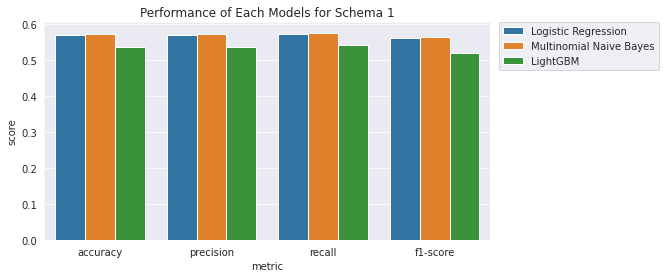

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 1")
plt.show()

## Schema 2

**Logistic Regression**

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.77      0.83      0.80       355
      wanita       0.84      0.78      0.81       413

    accuracy                           0.81       768
   macro avg       0.81      0.81      0.81       768
weighted avg       0.81      0.81      0.81       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.806
Precision score: 0.806
Recall score: 0.8077
F1 score: 0.8057


**Multinomial Naive Bayes**

In [ ]:
gender_pred = []

for gen_code in y_pred_multinb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.79      0.76      0.78       397
      wanita       0.76      0.78      0.77       371

    accuracy                           0.77       768
   macro avg       0.77      0.77      0.77       768
weighted avg       0.77      0.77      0.77       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7721
Precision score: 0.7721
Recall score: 0.7724
F1 score: 0.7721


**LightGBM**

In [ ]:
gender_pred = []

for gen_code in y_pred_lgb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.74      0.80      0.77       354
      wanita       0.82      0.76      0.79       414

    accuracy                           0.78       768
   macro avg       0.78      0.78      0.78       768
weighted avg       0.78      0.78      0.78       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7786
Precision score: 0.7786
Recall score: 0.7804
F1 score: 0.7783


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.806, 0.7721, 0.7786,
              0.806, 0.7721, 0.7786,
              0.8077, 0.7724, 0.7804,
              0.8057, 0.7721, 0.7783],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

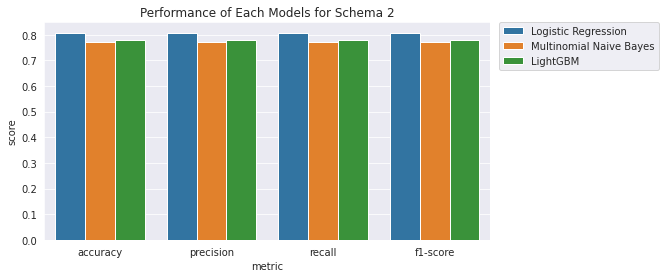

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 2")
plt.show()

## Schema 3

**Logistic Regression**

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.69      0.82      0.75       324
      wanita       0.85      0.73      0.79       444

    accuracy                           0.77       768
   macro avg       0.77      0.78      0.77       768
weighted avg       0.78      0.77      0.77       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7708
Precision score: 0.7708
Recall score: 0.7776
F1 score: 0.7694


**Multinomial Naive Bayes**

In [ ]:
gender_pred = []

for gen_code in y_pred_multinb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.77      0.81      0.79       363
      wanita       0.82      0.78      0.80       405

    accuracy                           0.79       768
   macro avg       0.79      0.79      0.79       768
weighted avg       0.79      0.79      0.79       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.793
Precision score: 0.793
Recall score: 0.7938
F1 score: 0.7928


**LightGBM**

In [ ]:
gender_pred = []

for gen_code in y_pred_lgb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.64      0.76      0.70       321
      wanita       0.80      0.69      0.74       447

    accuracy                           0.72       768
   macro avg       0.72      0.73      0.72       768
weighted avg       0.73      0.72      0.72       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7201
Precision score: 0.7201
Recall score: 0.7261
F1 score: 0.7182


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.7708, 0.793, 0.7201,
              0.7708, 0.793, 0.7201,
              0.7776, 0.7938, 0.7261,
              0.7694, 0.7928, 0.7182],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})


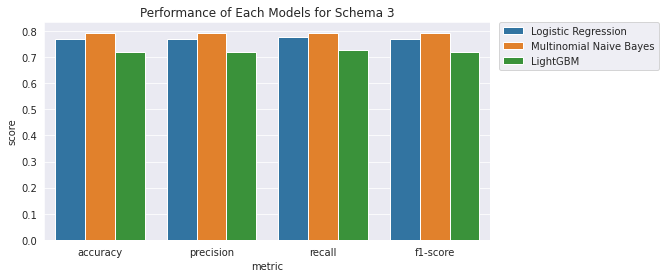

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 3")
plt.show()

## Schema 4

**Logistic Regression**

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.75      0.80      0.77       362
      wanita       0.81      0.76      0.78       406

    accuracy                           0.78       768
   macro avg       0.78      0.78      0.78       768
weighted avg       0.78      0.78      0.78       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7786
Precision score: 0.7786
Recall score: 0.7796
F1 score: 0.7785


**Multinomial Naive Bayes**

In [ ]:
gender_pred = []

for gen_code in y_pred_multinb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.79      0.75      0.77       403
      wanita       0.74      0.78      0.76       365

    accuracy                           0.76       768
   macro avg       0.76      0.76      0.76       768
weighted avg       0.77      0.76      0.76       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7643
Precision score: 0.7643
Recall score: 0.765
F1 score: 0.7642


**LightGBM**

In [ ]:
gender_pred = []

for gen_code in y_pred_lgb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.75      0.78      0.76       368
      wanita       0.79      0.76      0.77       400

    accuracy                           0.77       768
   macro avg       0.77      0.77      0.77       768
weighted avg       0.77      0.77      0.77       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7682
Precision score: 0.7682
Recall score: 0.7687
F1 score: 0.7681


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.7786, 0.7643, 0.7682,
              0.7786, 0.7643, 0.7682,
              0.7796, 0.765, 0.7687,
              0.7785, 0.7642, 0.7681],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

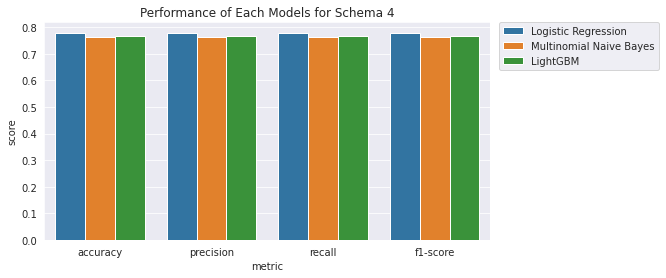

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 4")
plt.show()

## Schema 5

**Logistic Regression**

In [ ]:
gender_pred = []

for gen_code in y_pred_logreg:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.67      0.72      0.70       357
      wanita       0.74      0.69      0.72       411

    accuracy                           0.71       768
   macro avg       0.71      0.71      0.71       768
weighted avg       0.71      0.71      0.71       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.707
Precision score: 0.707
Recall score: 0.7081
F1 score: 0.7067


**Multinomial Naive Bayes**

In [ ]:
gender_pred = []

for gen_code in y_pred_multinb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.78      0.76      0.77       395
      wanita       0.75      0.77      0.76       373

    accuracy                           0.76       768
   macro avg       0.76      0.76      0.76       768
weighted avg       0.76      0.76      0.76       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.7643
Precision score: 0.7643
Recall score: 0.7645
F1 score: 0.7643


**LightGBM**

In [ ]:
gender_pred = []

for gen_code in y_pred_lgb:
  if gen_code == 0:
    gender_pred.append("wanita")
  else:
    gender_pred.append("pria")

df_res = pd.DataFrame({
    'id': df_test['id'].astype(int),
    'gender': gender_pred
})

df_res.drop(y_ignore_idx, inplace=True)

In [ ]:
print(classification_report(df_res['gender'], y_test[1]))

              precision    recall  f1-score   support

        pria       0.56      0.67      0.61       323
      wanita       0.72      0.62      0.67       445

    accuracy                           0.64       768
   macro avg       0.64      0.65      0.64       768
weighted avg       0.65      0.64      0.64       768



In [ ]:
print(f"Accuracy score: {round(accuracy_score(df_res['gender'], y_test[1]), 4)}")
print(f"Precision score: {round(precision_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"Recall score: {round(recall_score(df_res['gender'], y_test[1], average='macro'), 4)}")
print(f"F1 score: {round(f1_score(df_res['gender'], y_test[1], average='macro'), 4)}")

Accuracy score: 0.6419
Precision score: 0.6419
Recall score: 0.6456
F1 score: 0.6397


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.707, 0.7643, 0.6419,
              0.707, 0.7643, 0.6419,
              0.7081, 0.7645, 0.6456,
              0.7067, 0.7643, 0.6397],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

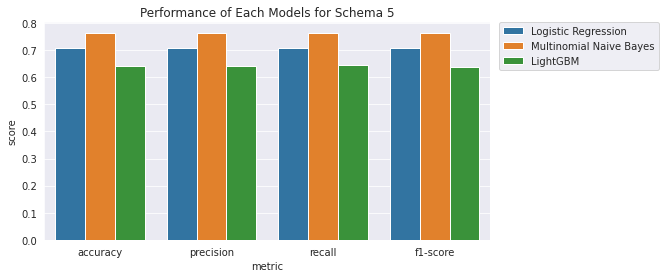

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 5")
plt.show()

# Error Analysis

In [ ]:
y_pred = pd.read_csv(path+"RESULT/GENDER CLASSIFICATION/20220421-res-gender-2.csv", header=None)

In [ ]:
y_pred.drop(y_ignore_idx, inplace=True)
df_test_profile.drop(y_ignore_idx, inplace=True)

In [ ]:
df = pd.concat([df_test_profile, y_pred[1], y_test[1]], axis=1)
df.columns = ['name', 'description', 'prediction', 'actual']

In [ ]:
wrong_pred = df[df['prediction']!=df['actual']]
wrong_pred

,name,description,prediction,actual
2,Florentin Anggraini Purnama,Apprentice Python programmer :)\n\nhttps://t.c...,pria,wanita
9,Lucy Wiryono,sportscaster. #motogp race host at TRANS7. #ho...,pria,wanita
30,mash🌻,survive!,pria,wanita
43,ji,kinda ia ...,pria,wanita
50,Asmara Wreksono,Creator of @WeRunDaWorldNFT. Open for commissi...,pria,wanita
...,...,...,...,...
1025,Riau Ega Agatha,U C D it. \n\nArchery Athlete Indonesia🇲🇨,wanita,pria
1033,Surliyadin,Professional Basketball Player for Bali United...,wanita,pria
1037,Andakara Prastawa,the official twitter page of andakara prastawa...,wanita,pria
1044,Aries Susanti Rahayu,Indonesian Sport Climbing Athlete\n\nhttps://t...,pria,wanita


In [ ]:
wrong_pred_sample_idx = np.random.choice(wrong_pred.index, 10)

In [ ]:
wrong_pred.loc[wrong_pred_sample_idx]

,name,description,prediction,actual
508,Pradipta Gitaya,He/Him/His | Loves to read slice of live & rom...,wanita,pria
591,Hanra ⌆,Discord: hanraa#1287,wanita,pria
391,aldila sutjiadi,University of Kentucky Women's Tennis 17' - Do...,pria,wanita
753,ᮕᮢᮛᮙ᮪ᮓ᮪ᮠᮔᮤ,Believe in process. Peringatan: akun ini adala...,wanita,pria
534,Fully Vaccinated ~,NaN,wanita,pria
625,AroundTheWorld,jkt,wanita,pria
848,Djono PD Metrotv,"Program Director at Metrotv, Multimedia Direct...",wanita,pria
576,Kicut,A twitter user,wanita,pria
785,LuckySuherman,I Ride my bike in the kitchen.,wanita,pria
819,WILLIAM GOZALI,✉️ : hi.willgoz@gmail.com | Instagram : willgoz,wanita,pria
